# 3. Linear Regression – Applied

Excercises from **Chapter 3** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

I've elected to use Python instead of R.

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats


### Q8. This question involves the use of simple linear regression on the Auto data set.

In [217]:
auto_df = pd.read_csv('./data/auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [218]:
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'],
             'qual': ['origin', 'name']}

quants = auto_df[datatypes['quant']].astype(np.float_)

auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

**(a)** Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:

- i. Is there a relationship between the predictor and the response?
- ii. How strong is the relationship between the predictor and the response?
- iii. Is the relationship between the predictor and the response positive or negative?
- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [219]:
# Let's start by implementing linear regression from scratch
# using numpy linear algebra

intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})

X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

def linear_model(X, y):
    """Estimation of parameteres for linear regressions model
    by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [222]:
# Our handrolled linear model doesn't provide the useful statistics 
# that summary(lm()) would provide in R. 
# For each estimated coefficient we would like to get the follow stats
# - coefficient 
# - standard error
# - t-value
# - p-value

# Add constant for bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})
#Load data
X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

# Predict coefficients and responses
coefficients = linear_model(X, y)
y_pred       = predict(beta, X)


# Calculate Mean Squared Error
MSE = np.sum(np.square(y_pred - y)) / y.size

# Variance of each variable in X
variance = MSE * (np.linalg.inv(X.T @ X).diagonal())  # To discuss: how is variance derived from MSE?

# Standard error of each variable in X
# given by Var(X) = SE(X)^2
standard_error = np.sqrt(var_beta)

# t-statistic given by t = β - 0 / SE(β)
t_statistic = coefficients / se_beta

# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))


# Present results
results = pd.DataFrame({'feature': X.columns,
                        'coefficients': coefficients,
                        'standard_error': standard_error,
                        't-statistic': t_statistic,
                        'P>|t|': p_values})

results.set_index('feature')

,coefficients,standard_error,t-statistic,P>|t|
feature,,,,
intercept,39.935861,0.715666,55.802376,0.0
horsepower,-0.157845,0.006429,-24.551848,0.0


In [221]:
# The statsmodels library provides a convenient means to get the
# same statistics

X = auto_df['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto_df['mpg']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 07 Sep 2018   Prob (F-statistic):           7.03e-81
Time:                        22:39:28   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

- i. Is there a relationship between the predictor and the response?

> Yes, the low P-value associated with the t-statistic for horsepower suggests so.

- ii. How strong is the relationship between the predictor and the response?

> For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg. 

- iii. Is the relationship between the predictor and the response positive or negative?

> Negative

- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [194]:
# predicted mpg associated with a horsepower of 98

def predict(model, X):
    return model.T @ X

X_ex = np.array([1, 98])

y_ex = predict(coefficients, X_ex)
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [195]:
# the associated 95% confidence and prediction intervals

model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [predict(model_min, X_t), predict(model_max, X_t)]
print(confidence_interval)

[21.814544959722646, 27.119609345302205]


**(b)** Plot the response and the predictor. Use the abline() function to display the least squares regression line.

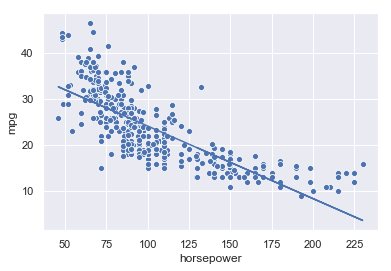

In [196]:
# Let's plot our predicted regression

df = pd.concat([auto_df['horsepower'], auto_df['mpg']], axis=1)
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)
ax.plot(auto_df['horsepower'], y_pred);

**(c)** Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

In [486]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Create the Design Matrix by adding constant bias variable
    intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
    X = np.array(pd.concat([intercept_const, X], axis=1))
    
    # Responses as np array
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = (X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    
    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    t    = lm_stats_df['studentised_residual']
    h_ii = lm_stats_df['leverage']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 12))
    
    # Studentised residual plot
    plt.subplot(221)
    # Q. Is y_pred correct x-val here?
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(222)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(223)
    # Q. Is y_pred correct x-val here?
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(224)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');


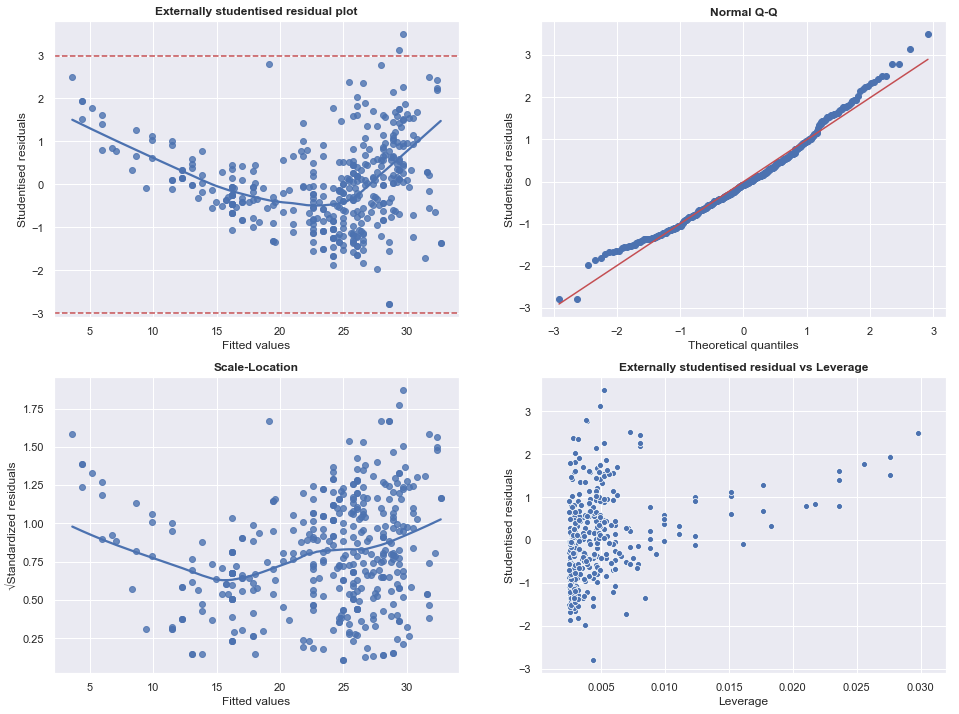

In [488]:
X = pd.concat([auto_df['horsepower']], axis=1)
y = auto_df['mpg']

lm_plot(lm_stats(X, y, y_pred))

The above residual plots show the relationship between the horsepower predictor and the mpg response. There are several things to note:

- the top-left residual plot suggests that the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. 
- the bottom-left standardised residual plot suggests that there is some heteroscedasticity in our predictor. Standardising the predictor looks like to help improve the fit of our model slightly, but there will still be significant non-linearity not accounted for.
- the top-right plot shows that our studentised residuals have a slightly non-normal distribution (ToDO: elaborate)
- the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.

